In this notebook we will use popular augmentations libruary, **Albumentations** (https://github.com/albu/albumentations) to perform augmentations of images together with multiple annotations, similar to those in the coco dataset. You can simply install it locally using: 

pip install albumentations

We consider an image for instance segmentation with several objects, each one having a lable, a bounding box (bbox), and a binary mask.

In [13]:
# Let's import needed libraries
import albumentations as A
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage.color import label2rgb
from pycocotools.coco import COCO
import random
%matplotlib inline

Set common constants. Hint: in practice you may create config.py file, add them there and then just do 

from configs import ...

In [4]:
IMG_SIZE = 1024
MAX_SIZE = 1024
IMAGE_ID = '1.jpg'

Set the path to the data. I uploaded an image and annotations here for convenience

In [5]:
input_path = '../../datasets/car_damage/val/'
image_filepath = os.path.join(input_path, IMAGE_ID)
annot_filepath = os.path.join(input_path,'COCO_val_annos.json')

Let's load an image with annotations

In [6]:
# load image
image = cv2.imread(image_filepath, cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # I am still wondering why OpenCV changed to BGR by default
height, width, channels = image.shape
height, width

(1024, 1024)

In [10]:
# load annotations
coco=COCO(annot_filepath)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
def img_masks_targets(df, img_id):
    """Select all targets of one image as an array of numbers
       Select all masks of one image as an array of RLE strings
       Output: 
            masks and targets for an image
    """
    # select all targets of one image as an array of numbers
    targets = df[df['ImageId'] == img_id]["ClassId"].values
    # select all masks of one image as an array is strings
    rles = df[df['ImageId'] == img_id]["EncodedPixels"].values
    return targets, rles

In [11]:
# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage'])
imgIds = coco.getImgIds(catIds=catIds )

In [14]:
random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

0 image id was selected at random from the [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] list


In [15]:
# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '1.jpg', 'flickr_url': '', 'height': 1024, 'id': 0, 'license': 1, 'width': 1024}


In [18]:
#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)
len(anns)

2

In [7]:
labels, rles = img_masks_targets(anns, img_id = IMAGE_ID)
num_instances = len(rles)
print(f'Number of instances on the image {len(rles)}')

Number of instances on the image 10


Masks for the image often come in the run-length encoded format (RLE). We need to convert them to binary masks to plot and/or augment. 
Here are some helpers for RLE encoding and decoding taken from here: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

In [8]:
def rle_decode(rle_str: str, mask_shape: tuple, mask_dtype=np.uint8):
    """Helper to decode RLE string to a binary mask"""
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(mask_shape[::-1]).T


def rle_encode(mask):
    """Helper to encode binary mask to RLE string"""
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle[1::2] -= rle[::2]
    return rle.tolist()

In [9]:
masks = np.zeros((len(rles), height, width), dtype = np.uint8)
for num in range(num_instances):
    masks[num, :, :] = rle_decode(rles[num], (height, width), np.uint8)

print(masks.shape) 

(10, 1685, 1123)


Define some helper functions to visualize data and labels

In [10]:
def visualize_bbox(img, bbox, color=(255, 255, 0), thickness=2):  
    """Helper to add bboxes to images 
    Args:
        img : image as open-cv numpy array
        bbox : boxes as a list or numpy array in pascal_voc fromat [x_min, y_min, x_max, y_max]  
        color=(255, 255, 0): boxes color 
        thickness=2 : boxes line thickness
    """
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img


def plot_image_anns(image, masks, boxes=None):
    """Helper to plot images with bboxes and masks 
    Args:
        image: image as open-cv numpy array, original and augmented
        masks: setof binary masks, original and augmented 
        bbox : boxes as a list or numpy array, original and augmented       
    """
    # glue binary masks together
    one_mask = np.zeros_like(masks[0])
    for i, mask in enumerate(masks):
        one_mask += (mask > 0).astype(np.uint8) * (11-i) # (11-i) so my inner artist is happy with the masks colors     
      
    if boxes is not None:
        for box in boxes:
            image = visualize_bbox(image, box)
            
    # for binary masks we get one channel and need to convert to RGB for visualization
    mask_rgb = label2rgb(one_mask, bg_label=0)            
        
    f, ax = plt.subplots(1, 2, figsize=(16, 16))             
    ax[0].imshow(image)
    ax[0].set_title('Original image')     
    ax[1].imshow(mask_rgb, interpolation='nearest')
    ax[1].set_title('Original mask')
    f.tight_layout()
    plt.show() 


def plot_image_aug(image, image_aug, masks, aug_masks, boxes, aug_boxes):
    """Helper to plot images with bboxes and masks and their augmented versions 
    Args:
        image, image_aug: image as open-cv numpy array, original and augmented
        masks, aug_masks:setof binary masks, original and augmented 
        bbox, aug_boxes : boxes as a list or numpy array, original and augmented       
    """
    # glue masks together
    one_mask = np.zeros_like(masks[0])
    for i, mask in enumerate(masks):
        one_mask += (mask > 0).astype(np.uint8) * (11-i)       
    
    one_aug_mask = np.zeros_like(aug_masks[0])
    for i, augmask in enumerate(aug_masks):
        one_aug_mask += (augmask > 0).astype(np.uint8) * (11-i) 
    
    for box in boxes:
        image = visualize_bbox(image, box)
    for augbox in aug_boxes:
        image_aug = visualize_bbox(image_aug, augbox)    
        
    # for binary masks we get one channel and need to convert to RGB for visualization
    mask_rgb = label2rgb(one_mask, bg_label=0)            
    mask_aug_rgb = label2rgb(one_aug_mask, bg_label=0) 
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))             
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original image')        
    ax[0, 1].imshow(image_aug)
    ax[0, 1].set_title('Augmented image')     
    ax[1, 0].imshow(mask_rgb, interpolation='nearest')
    ax[1, 0].set_title('Original mask')
    ax[1, 1].imshow(mask_aug_rgb, interpolation='nearest')
    ax[1, 1].set_title('Augmented mask')
    f.tight_layout()
    plt.show() 

Let's look at our image and corresponding masks

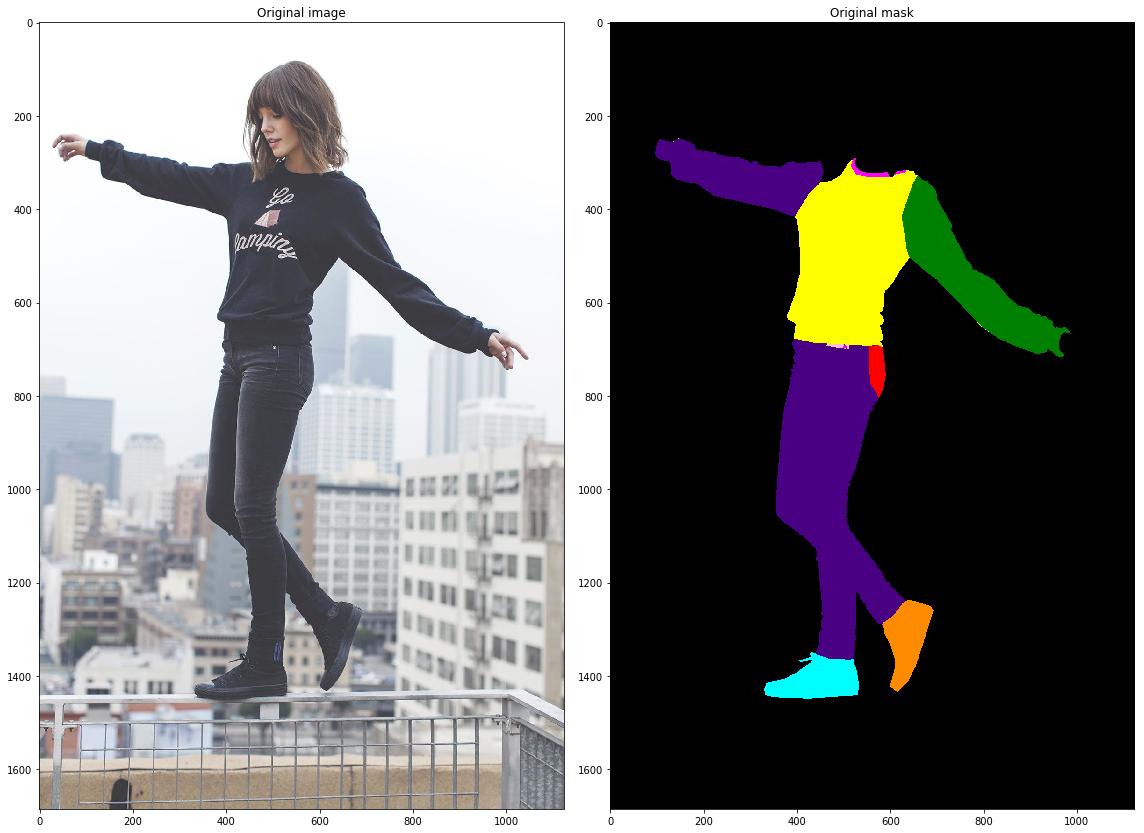

In [11]:
plot_image_anns(image, masks)

For instance segmentation models, like Mask-R-CNN and Co., you also need bounding boxes. COCO dataset provides them, but often you'll get only masks. 
No problem, we will generate bboxes from the masks then.

In [12]:
def get_boxes_from_masks(masks):
    """ Helper, gets bounding boxes from masks """
    coco_boxes = []
    for mask in masks:
        pos = np.nonzero(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])             
        coco_boxes.append([xmin, ymin, xmax, ymax])  
    coco_boxes = np.asarray(coco_boxes, dtype=np.float32) 
    
    return coco_boxes

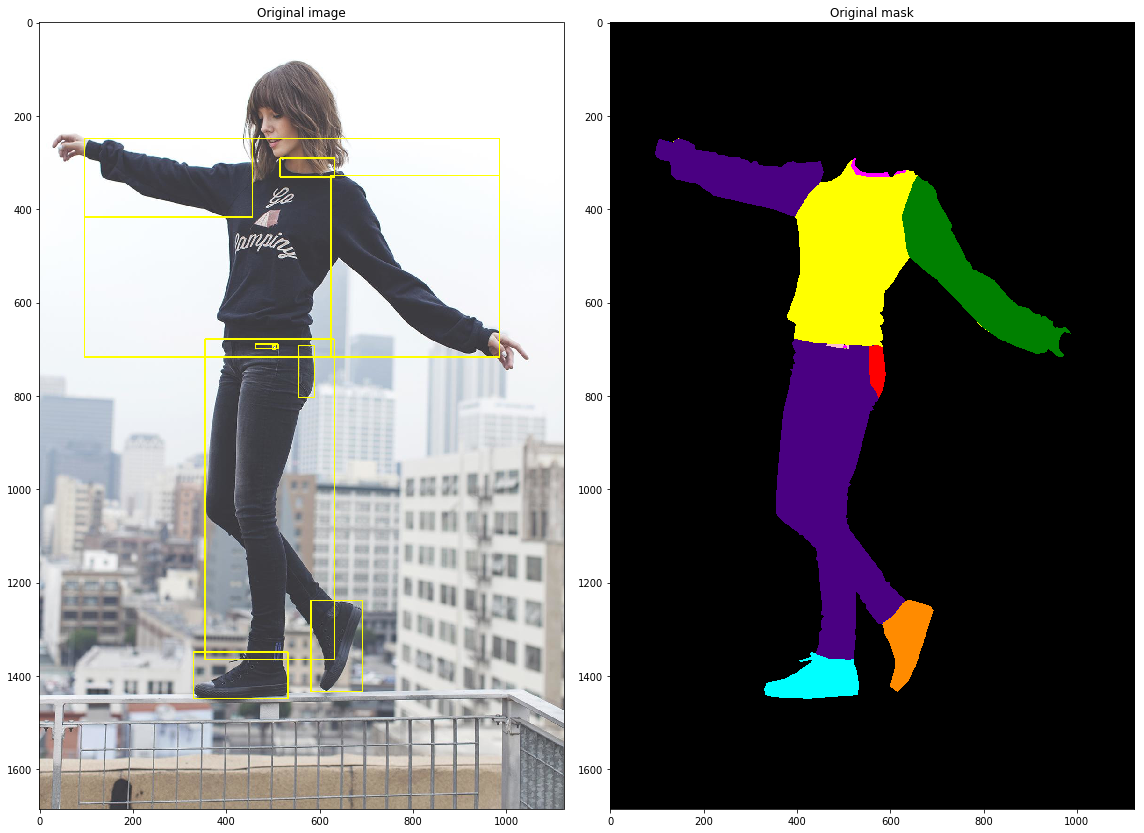

In [13]:
img = image.copy()
boxes = get_boxes_from_masks(masks)
plot_image_anns(img, masks, boxes)

Now let's create a list of transforms we want to apply for an image and annotations.

The choice of augmentations depends on your task. The common sets include: 

    D4 symmetry group augmentations for satellite imaging data; 
    
    crops, rotation and scales with varying brightness and colors for classification; 
    
    weather comditions simulation for camera-based self-driving tasks; 
    
    noise, blur and mild rotations for X-Ray chest scans, and so on.

Here we will make some lists for experimenting. In practice, it's better to create transforms.py file and put it all there. 

Please note: A.Normalize function -- normalizes image as in ImageNet dataset training. It's recommended to do it before sending data to your model, especially if you use pretrained on ImageNet backbone. Here I commented it for the visualization puproses (so that colors look right, my inner artist again :)) 

In [14]:
D4_transforms = [A.Resize(height//2, width//2, interpolation=cv2.INTER_LINEAR, p=1), 
                # D4 Group augmentations
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Transpose(p=0.5),                   
                #A.Normalize()
                ]

geom_transforms =  [A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, 
                       interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
                    # D4 Group augmentations
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.Transpose(p=0.5),
                    # crop and resize  
                    A.RandomSizedCrop((MAX_SIZE-100, MAX_SIZE), height//2, width//2, w2h_ratio=1.0, 
                                        interpolation=cv2.INTER_LINEAR, always_apply=False, p=0.5),  
                    A.Resize(height//2, width//2, interpolation=cv2.INTER_LINEAR, p=1), 
                    #A.Normalize(),
                    ]
                 
heavy_transforms = [A.RandomRotate90(),
                    A.Flip(),
                    A.Transpose(),
                    A.GaussNoise(),
                    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.7),                    
                    A.OneOf([
                        A.MotionBlur(p=0.2),
                        A.MedianBlur(blur_limit=3, p=0.1),
                        A.Blur(blur_limit=3, p=0.1),
                    ], p=0.5),                    
                    A.OneOf([                        
                        A.IAASharpen(),
                        A.IAAEmboss(),
                        A.RandomBrightnessContrast(),
                    ], p=0.5),
                    A.HueSaturationValue(p=0.3),
                    #A.Normalize(),
                    ]

We need to choose the bbox format, please refer to the library docs here: https://albumentations.readthedocs.io/en/latest/api/core.html#albumentations.core.composition.BboxParams

In [15]:
bbox_params={'format':'pascal_voc', 'min_area': 0, 'min_visibility': 0, 'label_fields': ['category_id']} 

Now we are ready to apply augmentations to the image, set of bboxes, and set of masks. It requires bboxes as a list, so we send it to the list format.

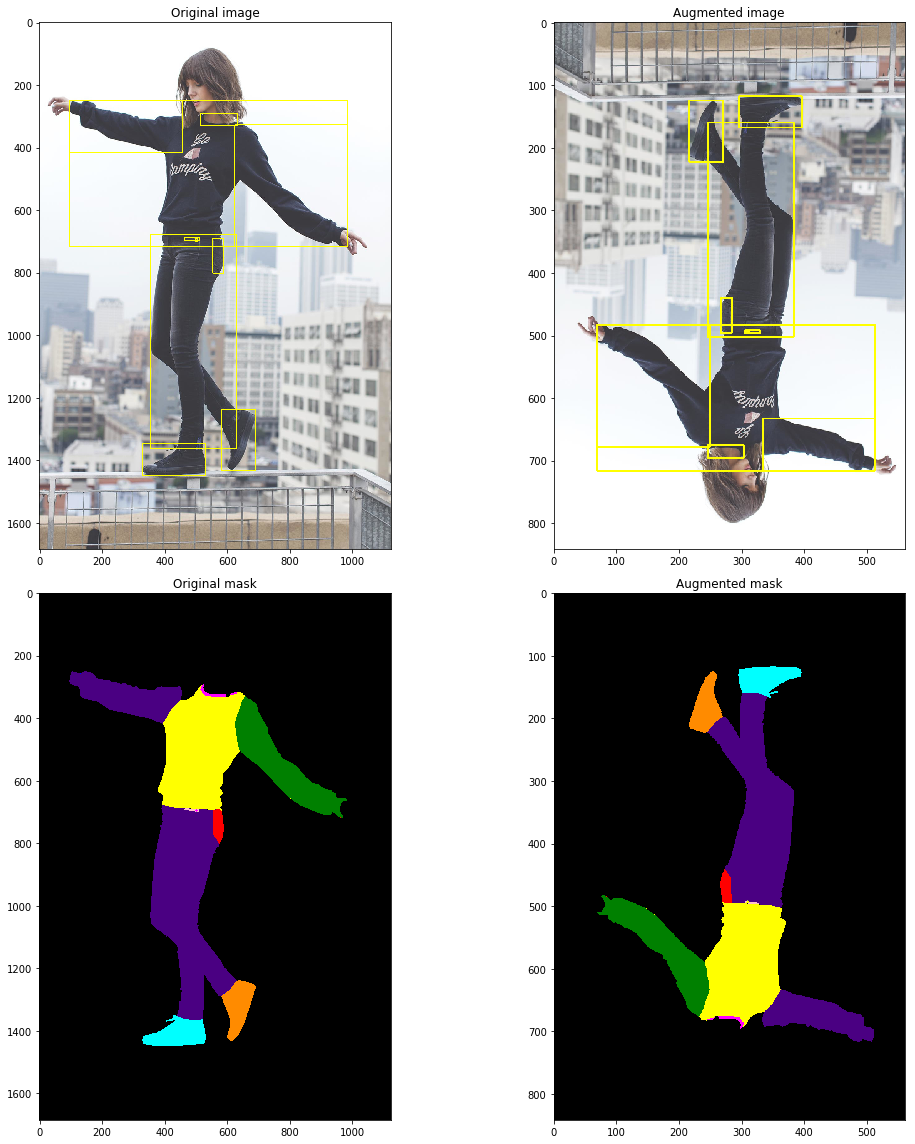

In [16]:
boxes = list(boxes) # you need to send bounding boxes to a list
img = image.copy()

augs = A.Compose(D4_transforms, bbox_params=bbox_params, p=1)       
augmented = augs(image=img, masks=masks, bboxes=boxes, category_id=labels)     
aug_img = augmented['image']
aug_masks = augmented['masks']
aug_boxes = augmented['bboxes']

plot_image_aug(img, aug_img, masks, aug_masks, boxes, aug_boxes)

Let's test some other augmentations sets

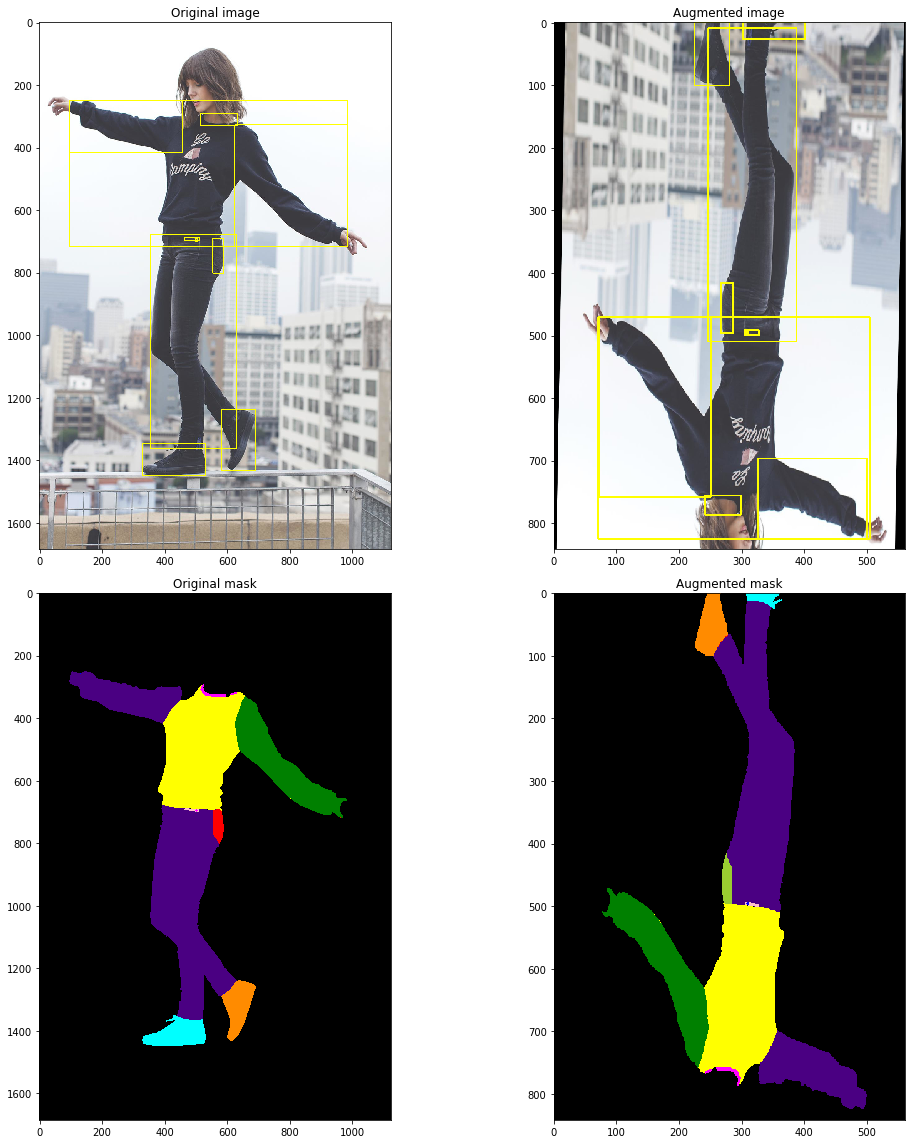

In [17]:
img = image.copy()

augs = A.Compose(geom_transforms, bbox_params=bbox_params, p=1)       
augmented = augs(image=img, masks=masks, bboxes=boxes, category_id=labels)     
aug_img = augmented['image']
aug_masks = augmented['masks']
aug_boxes = augmented['bboxes']

plot_image_aug(img, aug_img, masks, aug_masks, boxes, aug_boxes)

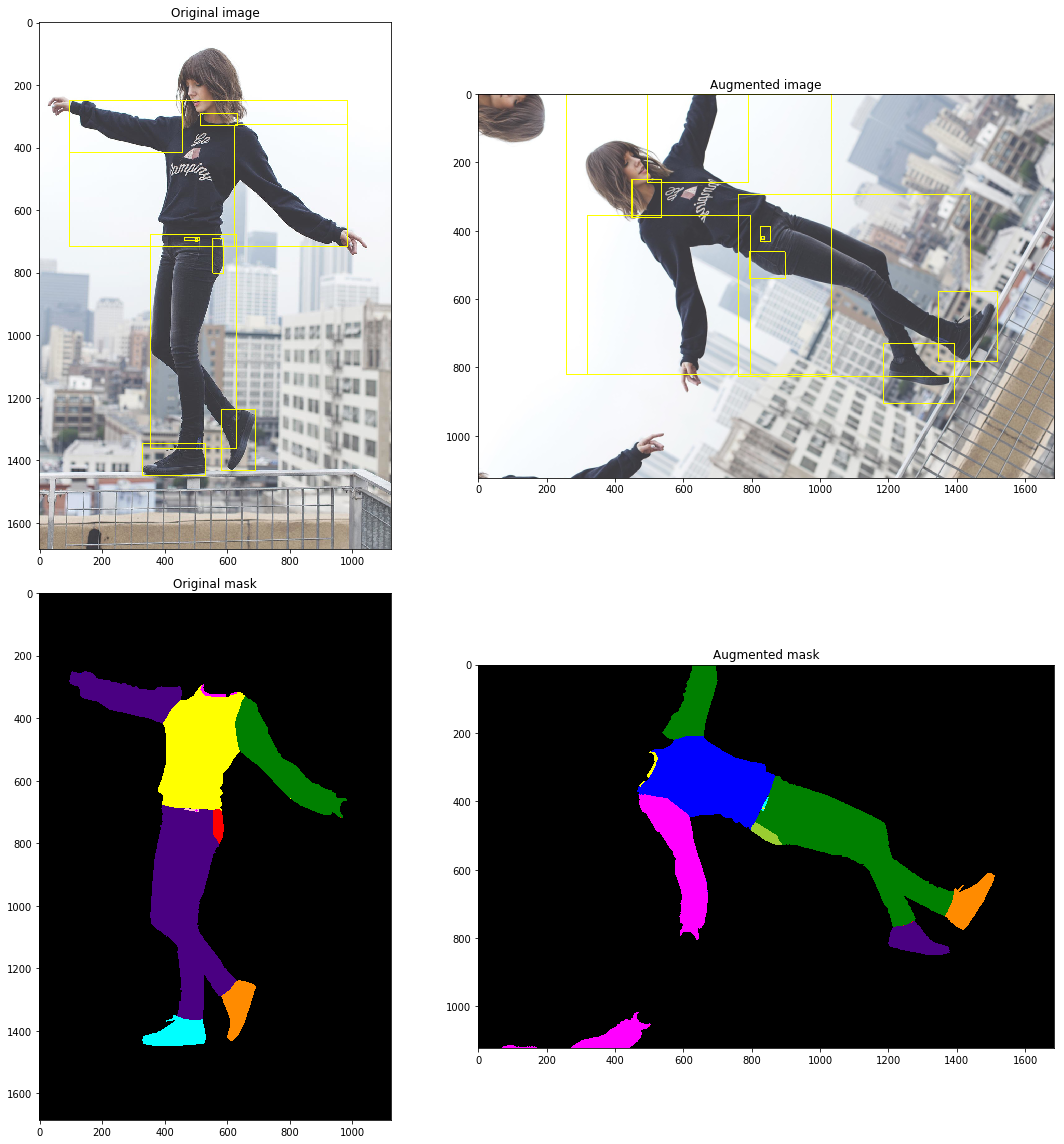

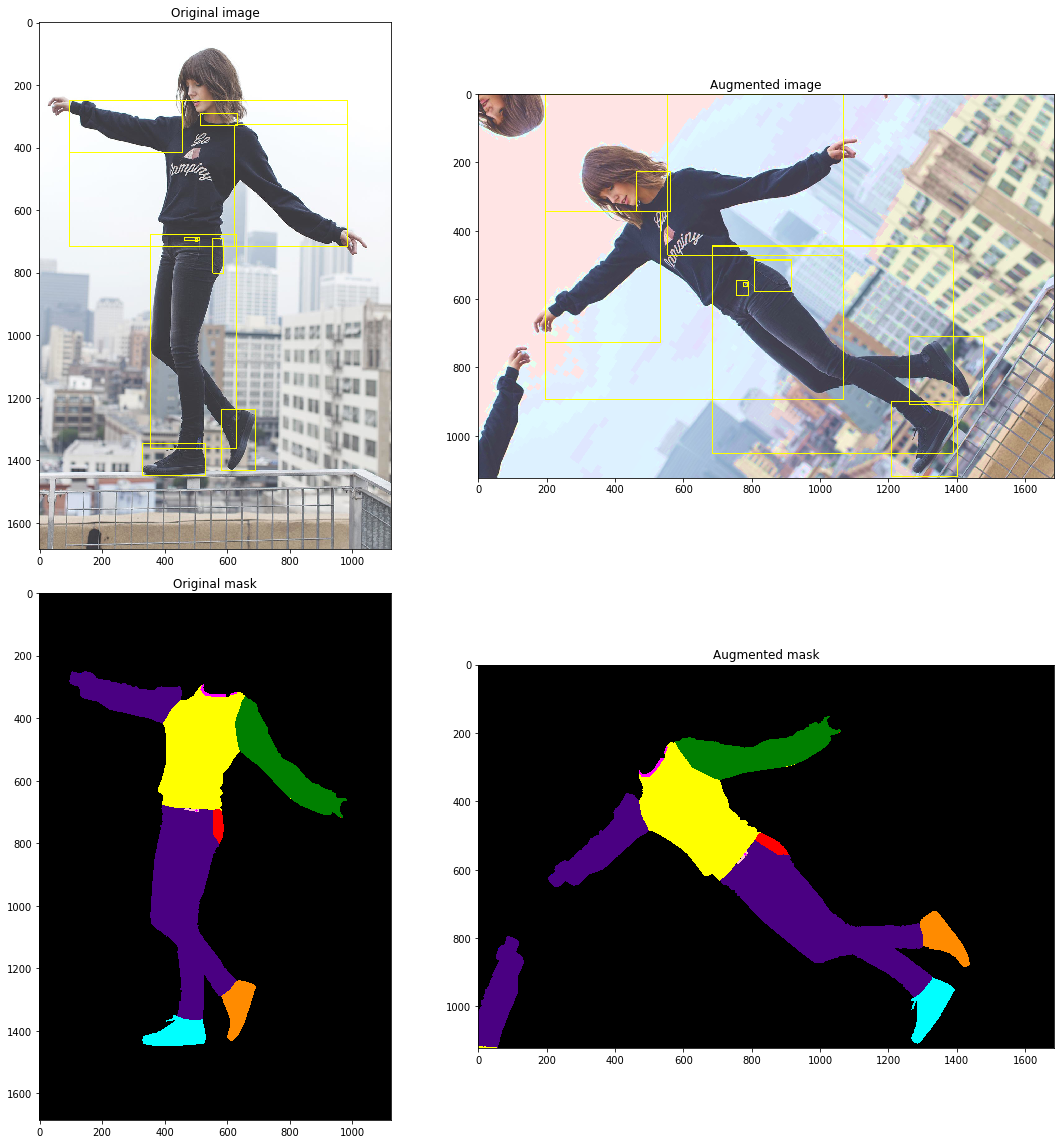

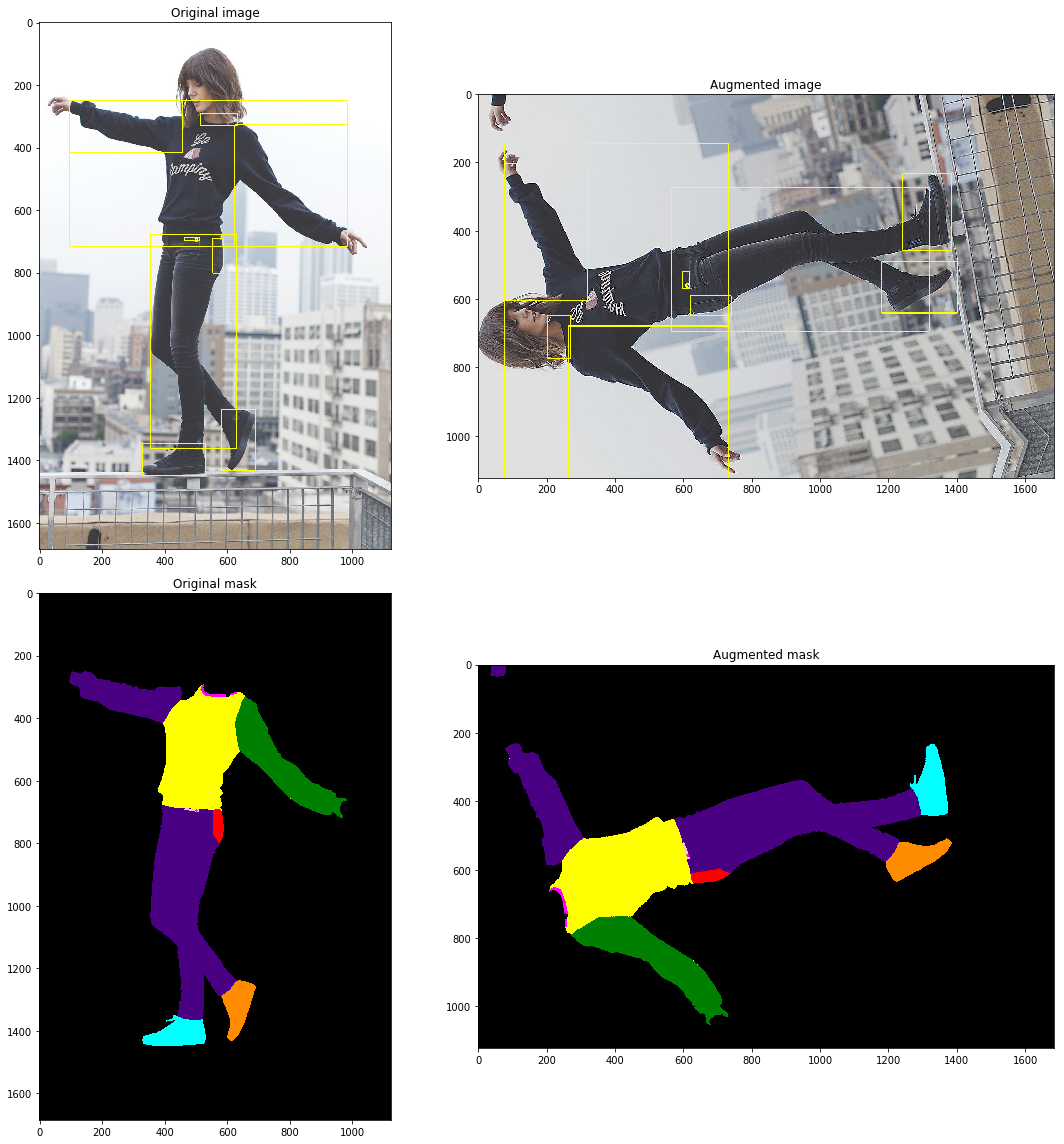

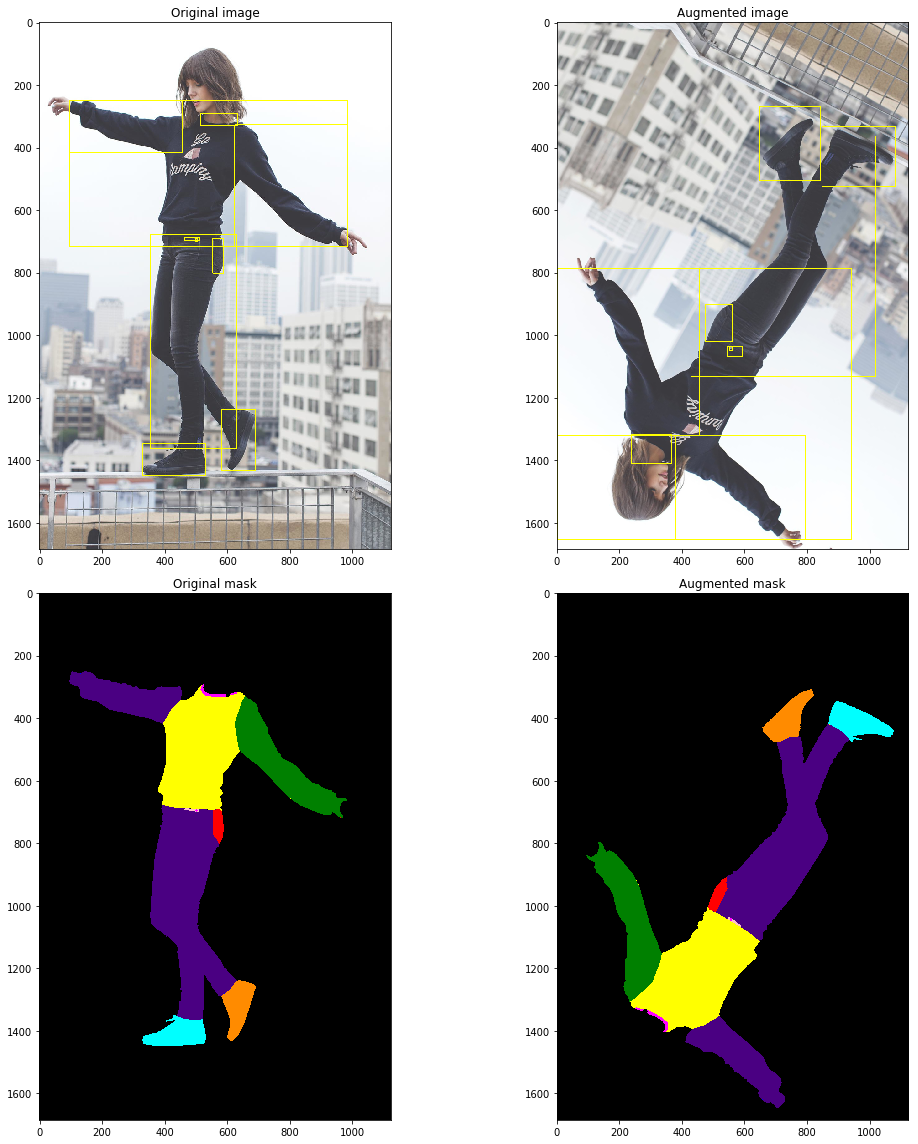

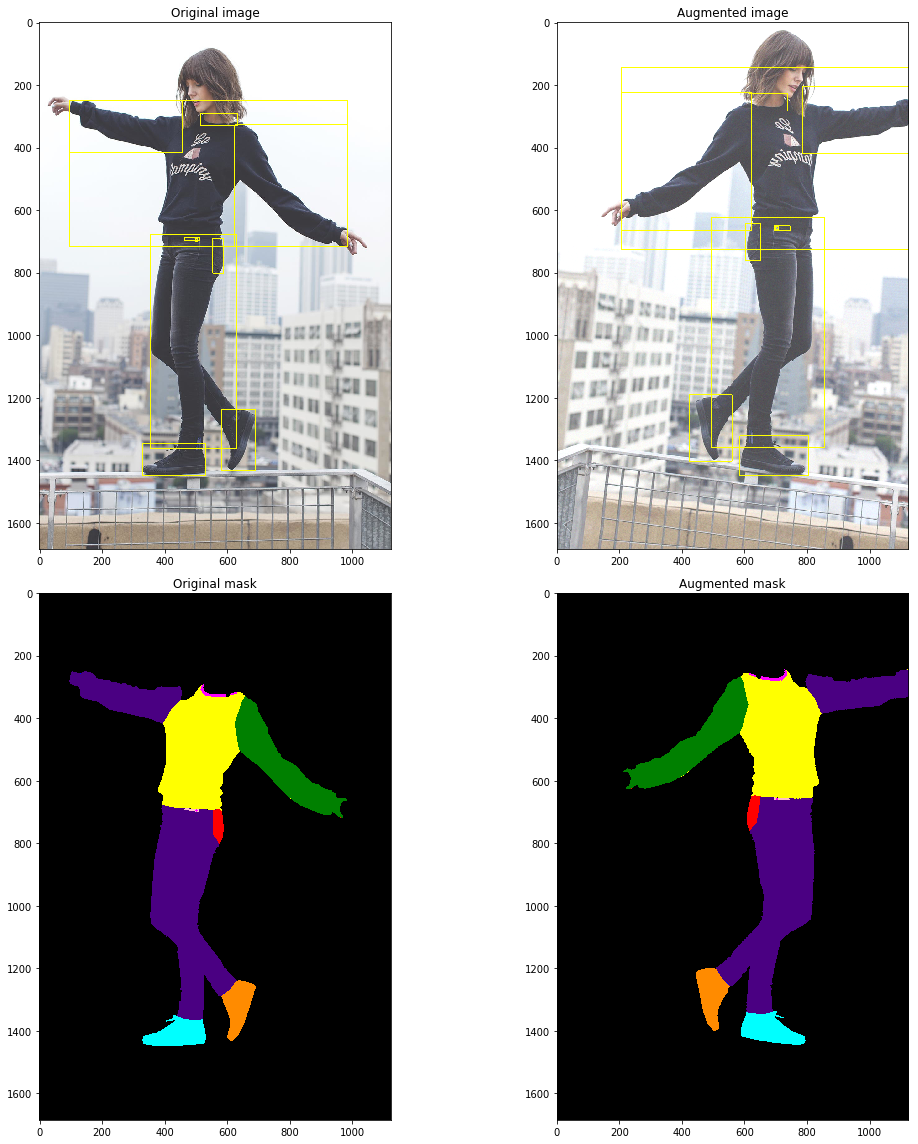

In [18]:
for i in range(5):
    img = image.copy()

    augs = A.Compose(heavy_transforms, bbox_params=bbox_params, p=1)       
    augmented = augs(image=img, masks=masks, bboxes=boxes, category_id=labels)     
    aug_img = augmented['image']
    aug_masks = augmented['masks']
    aug_boxes = augmented['bboxes']

    plot_image_aug(img, aug_img, masks, aug_masks, boxes, aug_boxes)

The last but not least, you probably want to augment your images on the fly during training. In this case you may want to include them in your Dataset. 
On PyTorch it it something like that:



In [19]:
import torch
import torch.utils.data

class DatasetAugs(torch.utils.data.Dataset):
    """
    My Dummy dataset for instance segmentation with augs
    
        :param fold: integer, number of the fold
        :param df: Dataframe with sample tokens
        :param debug: if True, runs the debugging on few images
        :param img_size: the desired image size to resize to        
        :param input_dir: directory with imputs and targets (and maps, optionally)   
        :param transforms: list of transformations
        
        """    
    def __init__(self, fold: int, df: pd.DataFrame,                  
                 debug: bool, img_size: int, 
                 input_dir: str, transforms = None, 
                 ):

        super(DatasetAugs, self).__init__()  # inherit it from torch Dataset
        self.fold = fold
        self.df = df        
        self.debug = debug
        self.img_size = img_size
        self.input_dir = input_dir
        self.transforms = transforms
        self.classes = df.classes.unique()
    
        if self.debug:
            self.df = self.df.head(16)
            print('Debug mode, samples: ', self.df.samples)  
        self.samples = list(self.df.samples)

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_filepath = '{}/{}'.format(self.input_dir, sample)        
        # load image
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED) 
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)     

        # get annotations
        labels, rles = img_masks_targets(df, img_id = sample)
        masks = np.zeros((len(rles), height, width), dtype = np.uint8)
        for num in range(num_instances):
            masks[num, :, :] = rle_decode(rles[num], (height, width), np.uint8)        
         
        # get boxes from masks
        boxes = get_boxes_from_masks(masks)    
        boxes = list(boxes)    
        
        # augment image and targets
        if self.transforms is not None:
            bbox_params={'format':'pascal_voc', 'min_area': 5, 'min_visibility': 0.5, 'label_fields': ['category_id']}
            augs = A.Compose(self.transforms, bbox_params=bbox_params, p=1)       
            augmented = augs(image=im, masks=masks, bboxes=boxes, category_id=labels)     
            im = augmented['image']
            masks = augmented['masks']
            boxes = augmented['bboxes']       
                                                    
        # targets to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)  

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd  
        
        im = torch.from_numpy(im.transpose(2,0,1)) # channels first
          
        return im, target

In [20]:
print('Thanks for reading and happy halloween !!!')

Thanks for reading and happy halloween !!!
